## Heart Attack Predictive Analysis: Group 44

### Introduction

Heart disease is a prevalent and life-threatening condition that affects millions of people worldwide. Early diagnosis and risk assessment are crucial in providing timely medical intervention and reducing the morbidity and mortality associated with this condition. In our data science project, we aim to leverage a [dataset](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) containing hospital data from Cleveland, Hungary, Switzerland, and VA Long Beach. However, we will specifically choose to work with the Cleveland data as it contains the most data from heart disease patients. The dataset contains 14 health-related variables, including the presence or absence of heart disease as the categorical variable. Using classification modelling, the data offers us a valuable opportunity to explore its relationship with heart disease. Hence, we propose to answer the question: Can we use medical laboratory test data available to us to predict whether a patient has heart disease?



### Preliminary exploratory data analysis



In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
library(RColorBrewer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [12]:
# creating column names for our data as it does not contain
our_col_names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

# reading in our data and storing as an object
heart_data <- read_csv("data/processed.cleveland.data", col_names = our_col_names) |>
    select(cp, trestbps, chol, fbs, restecg, num) |>
    mutate(num = ifelse(num %in% c(1, 2, 3, 4), 1, num))
head(heart_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


cp,trestbps,chol,fbs,restecg,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,145,233,1,2,0
4,160,286,0,2,1
4,120,229,0,2,1
3,130,250,0,0,0
2,130,204,0,2,0
2,120,236,0,0,0


In [28]:
# prepare data for splitting
split_obj <- initial_split(heart_data, prop = 0.8, strata = num)

# split and extract data
train_data <- training(split_obj)
test_data <- testing(split_obj)


# calculcate summary statistics
summary_diagnosis <- train_data |>
    group_by(num) |>
    summarize(count = n()) |>
    pivot_wider(names_from = num,
                values_from = count)

# summary_diagnosis

summary_means <- train_data |>
    select(trestbps, chol) |>
    summarize_all(mean, na.rm = TRUE)

# summary_means

summary_table <- cbind(summary_means, summary_diagnosis) |>
    rename("resting blood pressure (mean)" = trestbps,
          "serum cholesterol (mean)" = chol,
          "no disease" = `0`,
          "disease" = `1`)
           
summary_table

resting blood pressure (mean),serum cholesterol (mean),no disease,disease
<dbl>,<dbl>,<int>,<int>
130.8926,246.2521,131,111


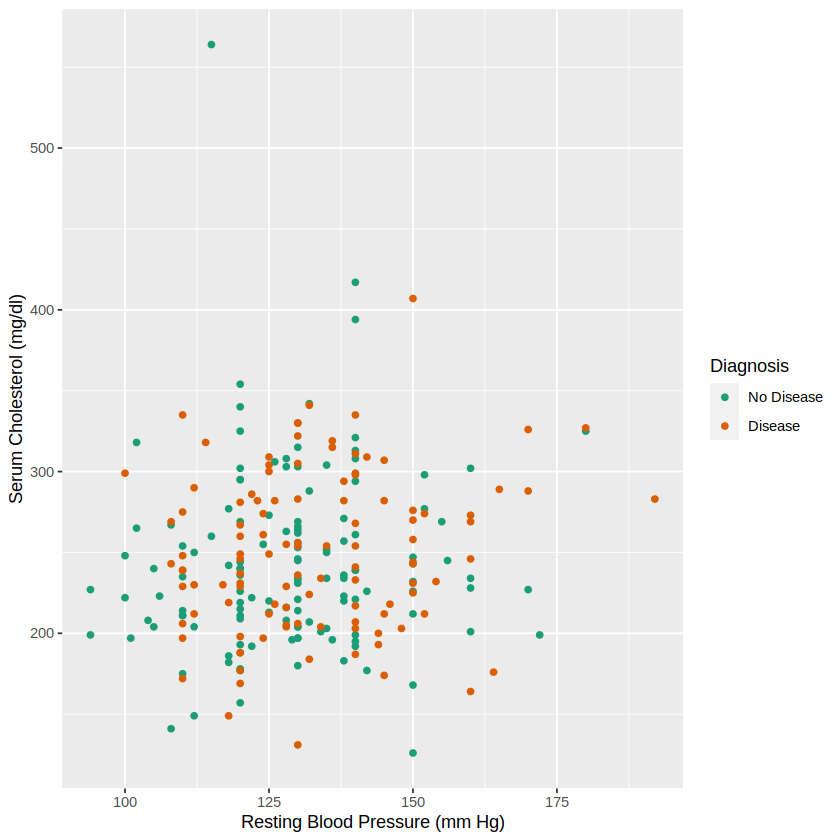

In [30]:
visulization1 <- train_data |>
    ggplot(aes(x=trestbps,  y=chol, colour= as_factor(num))) +
    geom_point() +
    labs(x="Resting Blood Pressure (mm Hg)", y="Serum Cholesterol (mg/dl)", colour = "Diagnosis") +
    scale_color_brewer(palette = "Dark2", labels=c("No Disease", "Disease"))

visulization1

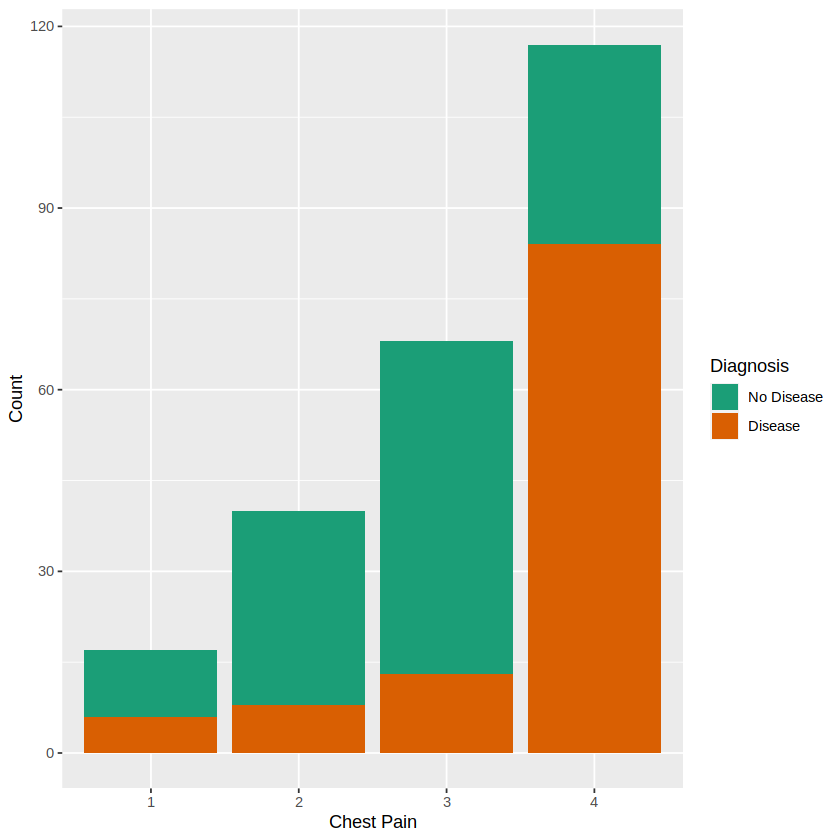

In [31]:
#9 cp: chest pain type
        #-- Value 1: typical angina
        #-- Value 2: atypical angina
        #-- Value 3: non-anginal pain
        #-- Value 4: asymptomatic

cat_cp <- train_data |>
    ggplot(aes(x = as_factor(cp), fill = as_factor(num))) +
    geom_bar(stat = "count") + 
    labs(x = "Chest Pain", y = "Count", fill = "Diagnosis") +
    scale_fill_brewer(palette = "Dark2", labels=c("No Disease", "Disease"))

cat_cp

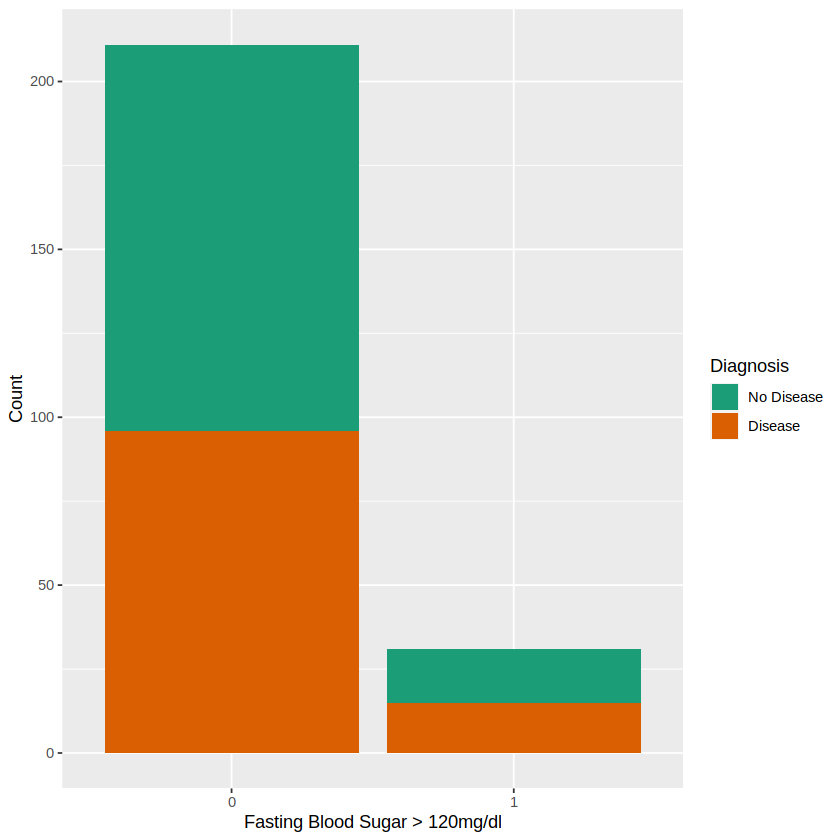

In [32]:
#16 fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)

cat_fbs <- train_data |>
    ggplot(aes(x = as_factor(fbs), fill = as_factor(num))) +
    geom_bar(stat = "count") + 
    labs(x = "Fasting Blood Sugar > 120mg/dl", y = "Count", fill = "Diagnosis") +
    scale_fill_brewer(palette = "Dark2", labels=c("No Disease", "Disease"))

cat_fbs

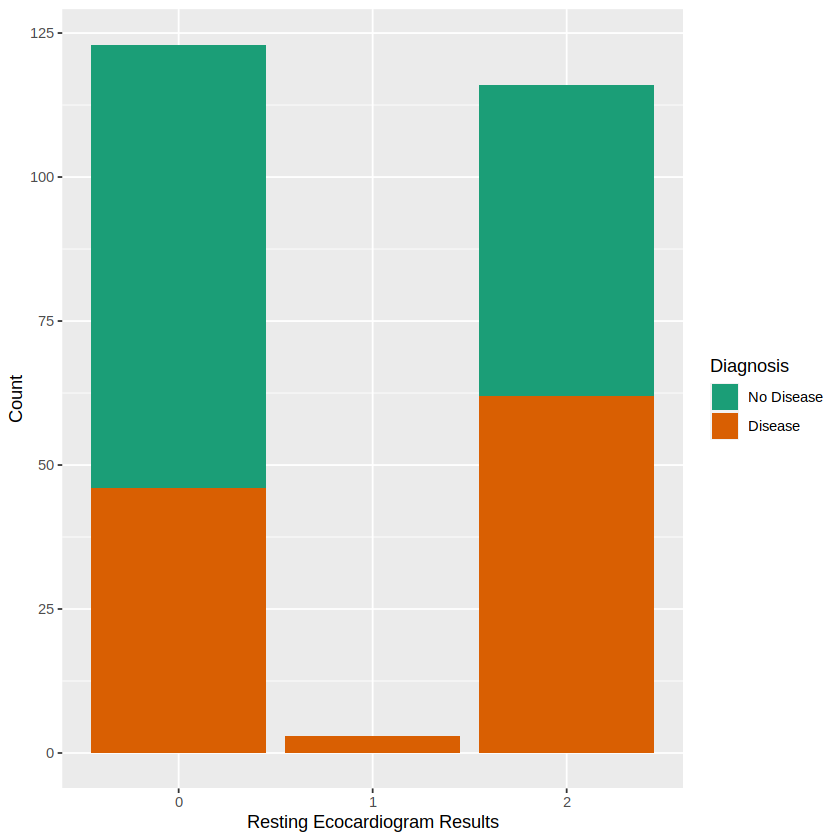

In [33]:
#19 restecg: resting electrocardiographic results
        #-- Value 0: normal
        #-- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
        #-- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

cat_restecg <- train_data |>
    ggplot(aes(x = as_factor(restecg), fill = as_factor(num))) +
    geom_bar(stat = "count") +
    labs(x = "Resting Ecocardiogram Results", y = "Count", fill = "Diagnosis") +
    scale_fill_brewer(palette = "Dark2", labels=c("No Disease", "Disease"))

cat_restecg

### Methods

To conduct our data analysis, we will be considering the following predictor variables:  cp (chest pain type: typical angina, atypical angina, non-anginal pain, asymptomatic), trestbp (resting blood pressure), restecg (resting ECG), fbs (fasting blood sugar), and chol (serum cholesterol). Aside from chest pain type, each one of these predictor variables are results of medical laboratory tests that are commonly requested by doctors, while the chest pain type accounts for the patient's experience in consideration of the diagnosis. The response variable will be num (diagnosis of heart disease). Using these variables, we will first explore the relationships between the predictor variables, with respect to the diagnosis of heart disease, by visualizing them on both a scatter plot and bar plots, as shown above. Once we get a sense of the relationships, we will use the K-nearest neighbors algorithm to predict the categorical class, which in this case is the diagnosis of heart disease. Before using the algorithm, we will first tune the classifier as well as consider how well the classifier performs in terms of accuracy, precision, and recall.

### Expected outcomes and significance

We expect to find that the predictor variables we have chosen will successfully and accurately predict the diagnosis of heart disease for a patient. As mentioned earlier, these predictor variables are results from medical laboratory tests, which are objective and conducted systematically. Chest pain type, on the other hand, accounts for the subjectivity of heart disease patients. Both considerations of subjectivity and objectivity ultimately ensures a well-rounded diagnosis. These findings could potentially have significant implications for early risk assessment and timely medical intervention. By improving the accuracy of heart disease classification, our findings can help guide healthcare professionals in making informed decisions and improve patient care outcomes. Finally, our findings may inspire further extrapolation of other predictive models for heart disease diagnosis, potentially leading to more accurate and personalized risk assessments that take into account a broader range of health and lifestyle factors.   